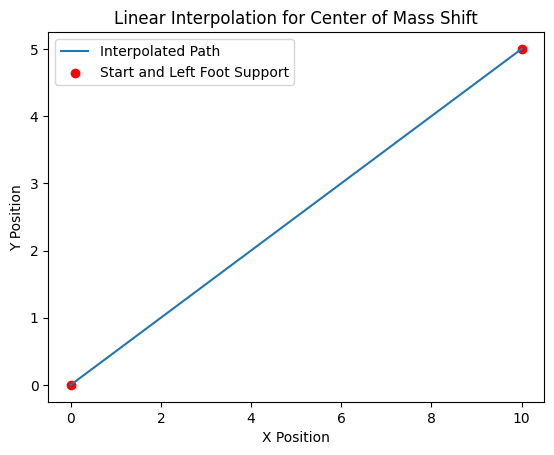

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义两个数据点
start_data = np.array([0, 0])  # [x₀, y₀] 开始数据
left_foot_support_data = np.array([10, 5])  # [x₁, y₁] 左脚支撑数据

# 生成插值的时间步长 (t从0到1)
t_values = np.linspace(0, 1, 100)

# 线性插值计算
interpolated_data = (1 - t_values[:, None]) * start_data + t_values[
    :, None
] * left_foot_support_data

# 绘图显示插值结果
plt.plot(interpolated_data[:, 0], interpolated_data[:, 1], label="Interpolated Path")
plt.scatter(
    [start_data[0], left_foot_support_data[0]],
    [start_data[1], left_foot_support_data[1]],
    color="red",
    label="Start and Left Foot Support",
)
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Linear Interpolation for Center of Mass Shift")
plt.show()


0.0010586480748404803
[11 11]


/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21147 (\N{CJK

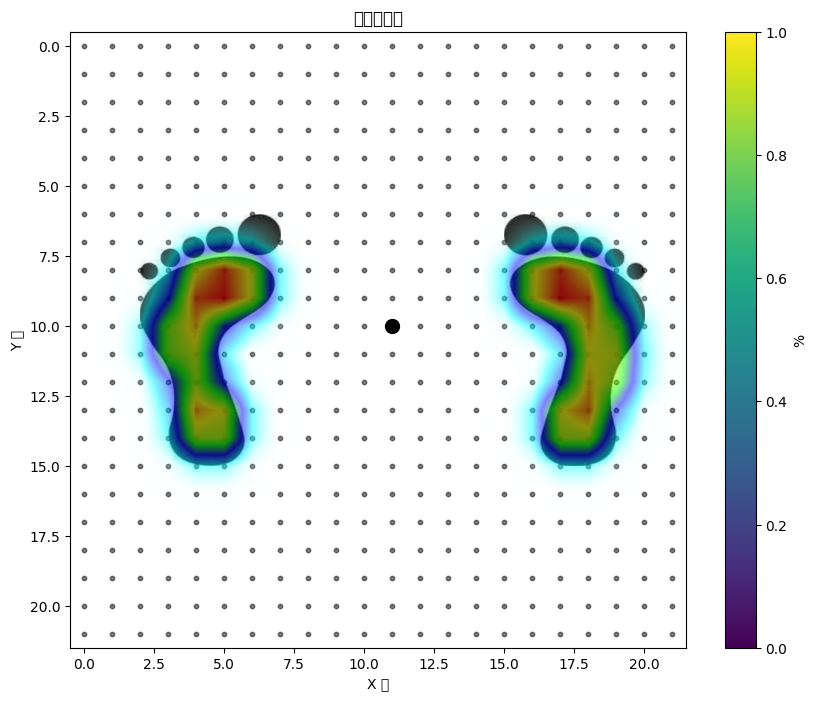

In [2]:
from cop_trajectory_analysis.data_loader import PressureDataLoader, CoordinateDataLoader
from cop_trajectory_analysis.cop_calculation import (
    left_map_rule,
    right_map_rule,
    calculate_distances,
    calculate_F_COP,
    calculate_cop_xy,
)
import numpy as np
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import random
import matplotlib.image as mpimg

pressure_loader=PressureDataLoader(file_path="data/pressure_data.csv")
pressure_data = pressure_loader.load_pressure()["2025-02-11T15:50:46"]
coordinate_loader = CoordinateDataLoader(file_path="data/coordinate_data.csv",left_map=left_map_rule,right_map=right_map_rule)
coordinate_data=coordinate_loader.load_coordinates()["2025-02-11T15:50:46"]
total_sensor_xy = coordinate_loader.get_total_coordinate()["2025-02-11T15:50:46"]
total_pressure=pressure_loader.get_total_pressure()["2025-02-11T15:50:46"]


# 计算压力中心坐标
cop_xy = calculate_cop_xy(pressures=total_pressure, coordinates=total_sensor_xy)
# 计算每个传感器到压力中心的距离
sensor_distance = calculate_distances(
    sensor_coords=total_sensor_xy, center_coords=cop_xy
)
# 计算压力中心的数值
F_COP = calculate_F_COP(pressures=total_pressure, distances=sensor_distance)

"""
以下是绘制热力图的代码
"""
cop_xy_int = np.array(cop_xy).astype(int)


max_pressure = np.max(total_pressure)
normalized_pressure = (total_pressure / max_pressure) + 2


# 自定义颜色映射
colors = [
    (1.0, 1.0, 1.0, 0.0),  # 白色
    (0.0, 1.0, 1.0, 1.0),  # 青色
    (0.0, 0.0, 1.0, 1.0),  # 蓝色
    (0.0, 1.0, 0.0, 1.0),  # 绿色
    (1.0, 1.0, 0.0, 1.0),  # 黄色
    (1.0, 0.0, 0.0, 1.0),  # 红色
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

figure_data = np.zeros(shape=(22, 22))
for (x, y), pressure in zip(total_sensor_xy, total_pressure):
    figure_data[x, y] = pressure

figure_data[cop_xy_int[0], cop_xy_int[1]] = np.floor(F_COP) / max_pressure

smoothed_data = gaussian_filter(figure_data, sigma=0.7)


max_smoothed = np.max(smoothed_data)
norma_smoothed = smoothed_data / max_smoothed

rotated_norma_smoothed = np.rot90(norma_smoothed)

n = norma_smoothed.shape[0]
cop_xy_int[1] = cop_xy_int[1] + 1

rotated_cop_xy = (cop_xy_int[1], n - 1 - cop_xy_int[0])
# rotated_cop_xy=np.rot90(cop_xy_int)
print(norma_smoothed[cop_xy_int[0], cop_xy_int[1]])


# 创建平滑热力图
plt.figure(figsize=(10, 8))
plt.imshow(
    rotated_norma_smoothed,
    cmap=cmap,
    interpolation="bilinear",
    vmin=0,
    vmax=0.99,
    zorder=6,
    alpha=0.5,
)


# 读取图片
left = mpimg.imread("assets/left-1.png")
right = mpimg.imread("assets/right-1.png")


# 显示图片并指定显示区域
plt.imshow(left, extent=[2, 7, 15, 6], zorder=5)  # 图片显示在 (2, 8) 和 (3, 7) 的区域
plt.imshow(
    right, extent=[15, 20, 15, 6], zorder=5
)  # 图片2显示在 (6, 9) 和 (2, 5) 的区域


plt.colorbar(label="%")
plt.title("平滑热力图")
plt.xlabel("X 轴")
plt.ylabel("Y 轴")
plt.scatter(rotated_cop_xy[0], rotated_cop_xy[1], color="black", s=100, zorder=5)
print(cop_xy_int)
# 创建点状背景
x, y = np.meshgrid(np.arange(figure_data.shape[1]), np.arange(figure_data.shape[0]))
plt.scatter(x, y, color="black", s=10, alpha=0.5, zorder=5)

plt.show()

0.9567742326126988
[ 4 12]


/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21147 (\N{CJK

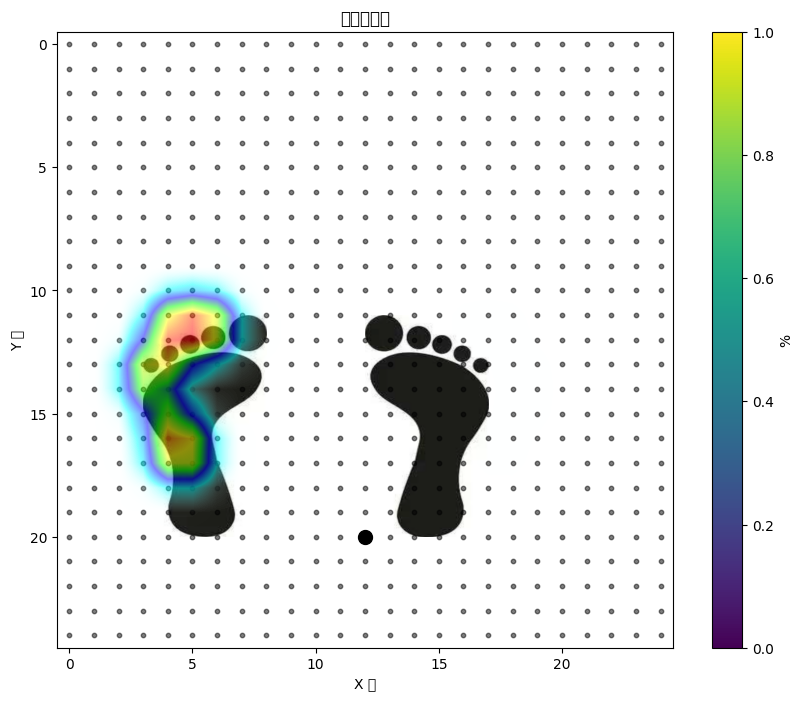

In [23]:
from cop_trajectory_analysis.data_loader import PressureDataLoader, CoordinateDataLoader
from cop_trajectory_analysis.cop_calculation import (
    left_map_rule,
    right_map_rule,
    calculate_distances,
    calculate_F_COP,
    calculate_cop_xy,
)
import numpy as np
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import random
import matplotlib.image as mpimg

pressure_loader = PressureDataLoader(file_path="data/pressure_data.csv")
pressure_data = pressure_loader.load_pressure()["2025-02-11T15:50:51"]
coordinate_loader = CoordinateDataLoader(
    file_path="data/coordinate_data.csv",
    left_map=left_map_rule,
    right_map=right_map_rule,
)
coordinate_data = coordinate_loader.load_coordinates()["2025-02-11T15:50:51"]
total_sensor_xy = coordinate_loader.get_total_coordinate()["2025-02-11T15:50:51"]
total_pressure = pressure_loader.get_total_pressure()["2025-02-11T15:50:51"]


# 计算压力中心坐标
cop_xy = calculate_cop_xy(pressures=total_pressure, coordinates=total_sensor_xy)
# 计算每个传感器到压力中心的距离
sensor_distance = calculate_distances(
    sensor_coords=total_sensor_xy, center_coords=cop_xy
)
# 计算压力中心的数值
F_COP = calculate_F_COP(pressures=total_pressure, distances=sensor_distance)

"""
以下是绘制热力图的代码
"""
cop_xy_int = np.array(cop_xy).astype(int)


max_pressure = np.max(total_pressure)
normalized_pressure = (total_pressure / max_pressure) + 2


# 自定义颜色映射
colors = [
    (1.0, 1.0, 1.0, 0.0),  # 白色
    (0.0, 1.0, 1.0, 1.0),  # 青色
    (0.0, 0.0, 1.0, 1.0),  # 蓝色
    (0.0, 1.0, 0.0, 1.0),  # 绿色
    (1.0, 1.0, 0.0, 1.0),  # 黄色
    (1.0, 0.0, 0.0, 1.0),  # 红色
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

figure_data = np.zeros(shape=(25, 25))
for (x, y), pressure in zip(total_sensor_xy, total_pressure):
    figure_data[x, y] = pressure

figure_data[cop_xy_int[0], cop_xy_int[1]] = np.floor(F_COP) / max_pressure

smoothed_data = gaussian_filter(figure_data, sigma=0.7)


max_smoothed = np.max(smoothed_data)
norma_smoothed = smoothed_data / max_smoothed

rotated_norma_smoothed = np.rot90(norma_smoothed)

n = norma_smoothed.shape[0]
cop_xy_int[1] = cop_xy_int[1] + 2
rotated_cop_xy = (cop_xy_int[1], n - 1 - cop_xy_int[0])
# rotated_cop_xy=np.rot90(cop_xy_int)
print(norma_smoothed[cop_xy_int[0], cop_xy_int[1]])


# 创建平滑热力图
plt.figure(figsize=(10, 8))
plt.imshow(
    rotated_norma_smoothed,
    cmap=cmap,
    interpolation="bilinear",
    vmin=0,
    vmax=0.99,
    zorder=6,
    alpha=0.5,
)


# 读取图片
left = mpimg.imread("assets/left-1.png")
right = mpimg.imread("assets/right-1.png")


# 显示图片并指定显示区域
plt.imshow(left, extent=[3, 8, 20, 11], zorder=5)  # 图片显示在 (2, 8) 和 (3, 7) 的区域
plt.imshow(
    right, extent=[12, 17, 20, 11], zorder=5
)  # 图片2显示在 (6, 9) 和 (2, 5) 的区域


plt.colorbar(label="%")
plt.title("平滑热力图")
plt.xlabel("X 轴")
plt.ylabel("Y 轴")
plt.scatter(rotated_cop_xy[0], rotated_cop_xy[1], color="black", s=100, zorder=5)
print(cop_xy_int)
# 创建点状背景
x, y = np.meshgrid(np.arange(figure_data.shape[1]), np.arange(figure_data.shape[0]))
plt.scatter(x, y, color="black", s=10, alpha=0.5, zorder=5)

plt.show()

In [24]:
import pandas as pd

def process_data():
    df= pd.read_csv('data/pressure_data.csv')
    # 每一个子元素都是2x16矩阵，第一个纬度代表左右脚，第二个纬度代表具体传感器的数值
    # np.zeros((2, 16))
    df = df.drop(df.columns[-1], axis=1)

    data = df.to_numpy()
    # 将每两行转换为一个2x16的矩阵
    n = data.shape[0] // 2
    result = np.array([data[i * 2 : (i + 1) * 2, :] for i in range(n)])
    return result
time_data=process_data()

In [25]:
from scipy.interpolate import CubicSpline

# 定义数据点（时间和对应的重心位置）
time_points = np.array([0, 1])  # t=0 对应开始数据, t=1 对应左脚支撑数据
positions = np.array([time_data[0], time_data[1]])  # 对应的重心位置

# 创建样条插值模型
cs = CubicSpline(time_points, positions)

# 在0到1之间生成插值点
t_values = np.linspace(0, 1, 100)
interpolated_data = cs(t_values)

# 将其转换为 2n x 16 的二维数组
reshaped_data = interpolated_data.reshape(-1, 17)

# 转换为 DataFrame
df = pd.DataFrame(reshaped_data, columns=[f'sensor{i}' for i in range(17)])

df['timestamp'] = [i//2 for i in range(len(df))]
df
df.to_csv('data/interpolated_data.csv',index=False)
# df
# print(interpolated_data.shape)
# print(interpolated_data.shape)

# # 绘图显示插值结果
# plt.plot(
#     interpolated_data[:, 0], interpolated_data[:, 1], label="Spline Interpolated Path"
# )
# plt.scatter(
#     [start_data[0], left_foot_support_data[0]],
#     [start_data[1], left_foot_support_data[1]],
#     color="red",
#     label="Start and Left Foot Support",
# )
# plt.legend()
# plt.xlabel("X Position")
# plt.ylabel("Y Position")
# plt.title("Cubic Spline Interpolation for Center of Mass Shift")
# plt.show()

In [7]:
from scipy.interpolate import CubicSpline

# 定义数据点（时间和对应的重心位置）
time_points = np.array([0, 1])  # t=0 对应开始数据, t=1 对应左脚支撑数据
positions = np.array([[11,11], [6,12]])  # 对应的重心位置

# 创建样条插值模型
cs = CubicSpline(time_points, positions)

# 在0到1之间生成插值点
t_values = np.linspace(0, 1, 100)
interpolated_data = cs(t_values)
interpolated_data

array([[11.        , 11.        ],
       [10.94949495, 11.01010101],
       [10.8989899 , 11.02020202],
       [10.84848485, 11.03030303],
       [10.7979798 , 11.04040404],
       [10.74747475, 11.05050505],
       [10.6969697 , 11.06060606],
       [10.64646465, 11.07070707],
       [10.5959596 , 11.08080808],
       [10.54545455, 11.09090909],
       [10.49494949, 11.1010101 ],
       [10.44444444, 11.11111111],
       [10.39393939, 11.12121212],
       [10.34343434, 11.13131313],
       [10.29292929, 11.14141414],
       [10.24242424, 11.15151515],
       [10.19191919, 11.16161616],
       [10.14141414, 11.17171717],
       [10.09090909, 11.18181818],
       [10.04040404, 11.19191919],
       [ 9.98989899, 11.2020202 ],
       [ 9.93939394, 11.21212121],
       [ 9.88888889, 11.22222222],
       [ 9.83838384, 11.23232323],
       [ 9.78787879, 11.24242424],
       [ 9.73737374, 11.25252525],
       [ 9.68686869, 11.26262626],
       [ 9.63636364, 11.27272727],
       [ 9.58585859,

(11, 8)


/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21147 (\N{CJK

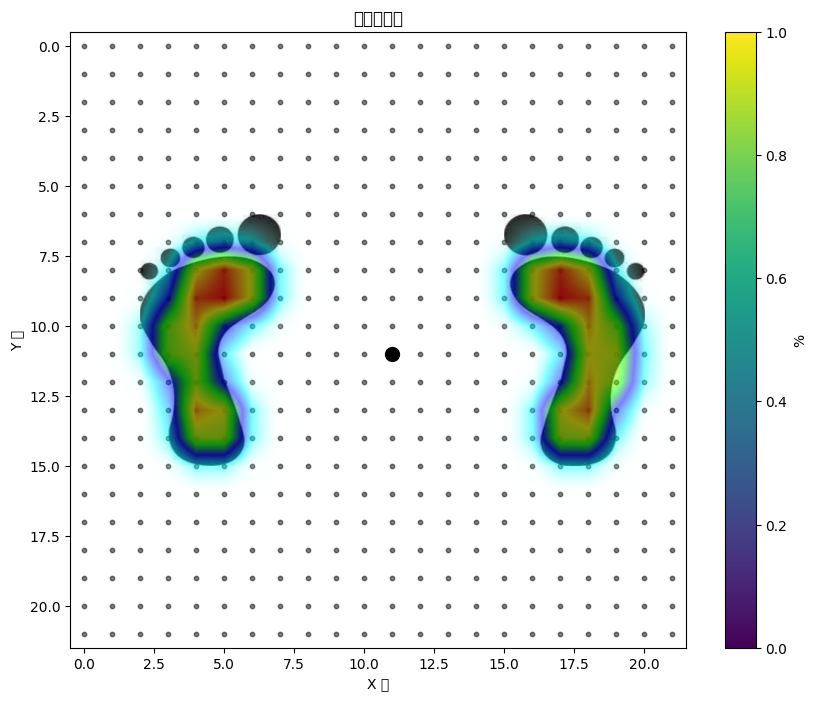

In [28]:
pressure_loader = PressureDataLoader(file_path="data/interpolated_data.csv")
pressure_data = pressure_loader.load_pressure()[50]
coordinate_loader = CoordinateDataLoader(
    file_path="data/coordinate_data.csv",
    left_map=left_map_rule,
    right_map=right_map_rule,
)
coordinate_data = coordinate_loader.load_coordinates()["2025-02-11T15:50:51"]
total_sensor_xy = coordinate_loader.get_total_coordinate()["2025-02-11T15:50:51"]
total_pressure = pressure_loader.get_total_pressure()[0]
# 计算压力中心坐标
cop_xy = calculate_cop_xy(pressures=total_pressure, coordinates=total_sensor_xy)
# 计算每个传感器到压力中心的距离
sensor_distance = calculate_distances(
    sensor_coords=total_sensor_xy, center_coords=cop_xy
)
# 计算压力中心的数值
F_COP = calculate_F_COP(pressures=total_pressure, distances=sensor_distance)

"""
以下是绘制热力图的代码
"""
cop_xy_int = np.array(cop_xy).astype(int)


max_pressure = np.max(total_pressure)
normalized_pressure = (total_pressure / max_pressure) + 2


# 自定义颜色映射
colors = [
    (1.0, 1.0, 1.0, 0.0),  # 白色
    (0.0, 1.0, 1.0, 1.0),  # 青色
    (0.0, 0.0, 1.0, 1.0),  # 蓝色
    (0.0, 1.0, 0.0, 1.0),  # 绿色
    (1.0, 1.0, 0.0, 1.0),  # 黄色
    (1.0, 0.0, 0.0, 1.0),  # 红色
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

figure_data = np.zeros(shape=(22, 22))
for (x, y), pressure in zip(total_sensor_xy, total_pressure):
    figure_data[x, y] = pressure

figure_data[cop_xy_int[0], cop_xy_int[1]] = np.floor(F_COP) / max_pressure

smoothed_data = gaussian_filter(figure_data, sigma=0.7)


max_smoothed = np.max(smoothed_data)
norma_smoothed = smoothed_data / max_smoothed

rotated_norma_smoothed = np.rot90(norma_smoothed)

n = norma_smoothed.shape[0]
cop_xy_int[0] = cop_xy_int[0] + 2

cop_xy_int[1] = cop_xy_int[1] + 1

# print(cop_xy_int)
# 旋转后的坐标 要从[11,11]转移到[6,12]
rotated_cop_xy = (cop_xy_int[1], n - 1 - cop_xy_int[0])
print(rotated_cop_xy)
# rotated_cop_xy=np.rot90(cop_xy_int)
# print(norma_smoothed[cop_xy_int[0], cop_xy_int[1]])


# 创建平滑热力图
plt.figure(figsize=(10, 8))
plt.imshow(
    rotated_norma_smoothed,
    cmap=cmap,
    interpolation="bilinear",
    vmin=0,
    vmax=0.99,
    zorder=6,
    alpha=0.5,
)


# 读取图片
left = mpimg.imread("assets/left-1.png")
right = mpimg.imread("assets/right-1.png")


# 显示图片并指定显示区域
plt.imshow(left, extent=[2, 7, 15, 6], zorder=5)  # 图片显示在 (2, 8) 和 (3, 7) 的区域
plt.imshow(
    right, extent=[15, 20, 15, 6], zorder=5
)  # 图片2显示在 (6, 9) 和 (2, 5) 的区域


plt.colorbar(label="%")
plt.title("平滑热力图")
plt.xlabel("X 轴")
plt.ylabel("Y 轴")
plt.scatter(11, 11, color="black", s=100, zorder=5)
# 创建点状背景
x, y = np.meshgrid(np.arange(figure_data.shape[1]), np.arange(figure_data.shape[0]))
plt.scatter(x, y, color="black", s=10, alpha=0.5, zorder=5)

plt.show()

/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25554 (\N{CJK UNIFIED IDEOGRAPH-63D2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mayphyr/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK

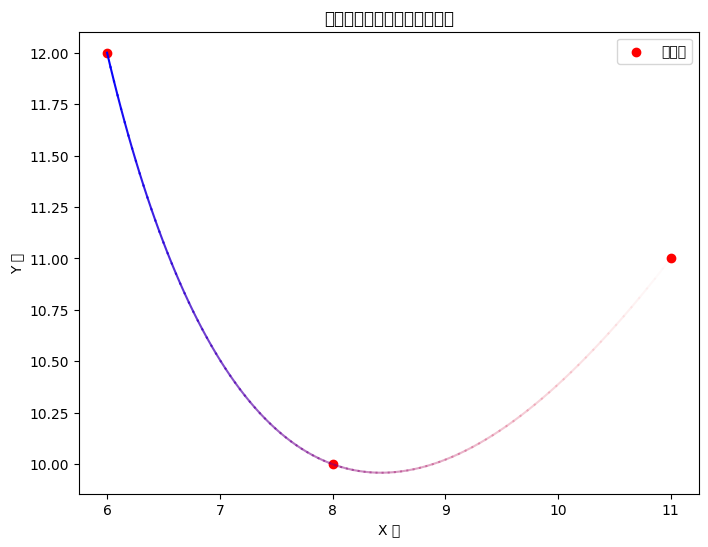

In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# 定义数据点（时间和对应的重心位置）
time_points = np.array([0, 0.5, 1])
positions = np.array([[11, 11], [8, 10], [6, 12]])

# 创建样条插值模型
cs = CubicSpline(time_points, positions)

# 在0到1之间生成插值点
t_values = np.linspace(0, 1, 100)
interpolated_data = cs(t_values)

# 绘制轨迹和彗星拖尾效果
plt.figure(figsize=(8, 6))
for i in range(1, len(interpolated_data)):
    alpha = i / len(interpolated_data)  # 透明度
    plt.plot(
        interpolated_data[i - 1 : i + 1, 0],
        interpolated_data[i - 1 : i + 1, 1],
        color=(1 - alpha, 0, alpha),
        alpha=alpha,
    )  # 颜色从红到蓝

plt.scatter(positions[:, 0], positions[:, 1], color="red", label="控制点")
plt.legend()
plt.xlabel("X 轴")
plt.ylabel("Y 轴")
plt.title("样条插值轨迹与彗星拖尾效果")
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import cv2
def create_heatmap(
    index,
    total_sensor_xy,
    total_pressure,
    rotated_cop_xy_list,
    out_video
):
    # 自定义颜色映射
    colors = [
        (1.0, 1.0, 1.0, 0.0),  # 白色
        (0.0, 1.0, 1.0, 1.0),  # 青色
        (0.0, 0.0, 1.0, 1.0),  # 蓝色
        (0.0, 1.0, 0.0, 1.0),  # 绿色
        (1.0, 1.0, 0.0, 1.0),  # 黄色
        (1.0, 0.0, 0.0, 1.0),  # 红色
    ]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
    figure_data = np.zeros(shape=(22, 22))
    for (x, y), pressure in zip(total_sensor_xy, total_pressure):
        figure_data[x, y] = pressure

    smoothed_data = gaussian_filter(figure_data, sigma=0.7)
    max_smoothed = np.max(smoothed_data)
    norma_smoothed = smoothed_data / max_smoothed

    rotated_norma_smoothed = np.rot90(norma_smoothed)

    # 创建平滑热力图
    plt.figure(figsize=(10, 8))
    plt.imshow(
        rotated_norma_smoothed,
        cmap=cmap,
        interpolation="bilinear",
        vmin=0,
        vmax=0.99,
        zorder=6,
        alpha=0.5,
    )
    # 读取图片
    left = mpimg.imread("assets/left-1.png")
    right = mpimg.imread("assets/right-1.png")
    # 显示图片并指定显示区域
    plt.imshow(left, extent=[2, 7, 15, 6], zorder=5)  # 图片显示在 (2, 8) 和 (3, 7) 的区域
    plt.imshow(
        right, extent=[15, 20, 15, 6], zorder=5
    )  # 图片2显示在 (6, 9) 和 (2, 5) 的区域
    plt.colorbar(label="%")
    plt.title("平滑热力图")
    plt.xlabel("X 轴")
    plt.ylabel("Y 轴")

    tail_length = 50
    for i, point in enumerate(rotated_cop_xy_list):
        if i < index:
            # 当前点之后的点，形成拖尾效果
            alpha = min((index - i) / tail_length, 1)  # 透明度
            plt.scatter(
                *point,
                edgecolor=(1 - alpha, 0, alpha),
                facecolor="none",
                s=5,
                zorder=5,
                alpha=alpha
            )  # 其他点为空心
        elif i == index:
            plt.scatter(*point, color="red", s=25, zorder=5)  # 突出显示当前点
        else:
            plt.scatter(
                *point, edgecolor="black", facecolor="none", s=5, zorder=5, alpha=0.2
            )  # 其他点为空心

    plt.plot(
        rotated_cop_xy_list[:, 0],
        rotated_cop_xy_list[:, 1],
        color="grey",
        linestyle="--",
    )  # 连接轨迹

    # plt.scatter(rotated_cop_xy_list[index][0],rotated_cop_xy_list[index][1], color="black", s=100, zorder=5)
    # 创建点状背景
    x, y = np.meshgrid(np.arange(figure_data.shape[1]), np.arange(figure_data.shape[0]))
    plt.scatter(x, y, color="black", s=10, alpha=0.5, zorder=5)
    # 保存当前帧
    plt.savefig('temp_frame.png')
    plt.close()

    # 读取帧并写入视频
    img = cv2.imread('temp_frame.png')
    out_video.write(img)

def create_image_data(index):
    pressure_loader = PressureDataLoader(file_path="data/interpolated_data.csv")
    pressure_data = pressure_loader.load_pressure()[index]
    coordinate_loader = CoordinateDataLoader(
        file_path="data/coordinate_data.csv",
        left_map=left_map_rule,
        right_map=right_map_rule,
    )
    coordinate_data = coordinate_loader.load_coordinates()["2025-02-11T15:50:51"]
    total_sensor_xy = coordinate_loader.get_total_coordinate()["2025-02-11T15:50:51"]
    total_pressure = pressure_loader.get_total_pressure()[index]
    return total_sensor_xy,total_pressure
    # # 计算压力中心坐标
    # cop_xy = calculate_cop_xy(pressures=total_pressure, coordinates=total_sensor_xy)
    # # 计算每个传感器到压力中心的距离
    # sensor_distance = calculate_distances(
    #     sensor_coords=total_sensor_xy, center_coords=cop_xy
    # )
    # # 计算压力中心的数值
    # F_COP = calculate_F_COP(pressures=total_pressure, distances=sensor_distance)
def create_rotated_cop_xy():
    # 定义数据点（时间和对应的重心位置）
    time_points = np.array([0,0.5,1])  # t=0 对应开始数据, t=1 对应左脚支撑数据
    positions = np.array([[11, 11],[7.5,10], [5.73, 12]])  # 对应的重心位置

    # 创建样条插值模型
    cs = CubicSpline(time_points, positions)

    # 在0到1之间生成插值点
    t_values = np.linspace(0, 1, 100)
    interpolated_data = cs(t_values)
    return interpolated_data

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import cv2

rotated_cop_xy_list=create_rotated_cop_xy()
# rotated_cop_xy_list
# 视频设置
size = (1000, 800)  # 根据实际图片大小设置
out = cv2.VideoWriter("output_video.avi", cv2.VideoWriter_fourcc(*"XVID"), 10, size)
for t in range(100):
    totoal_sensor_xy, total_pressure = create_image_data(t)
    create_heatmap(
        index=t,
        total_sensor_xy=totoal_sensor_xy,
        total_pressure=total_pressure,
        rotated_cop_xy_list=rotated_cop_xy_list,
        out_video=out
    )
out.release()

/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_25132/1380356851.py:89: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  plt.savefig('temp_frame.png')
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_25132/1380356851.py:89: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  plt.savefig('temp_frame.png')
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_25132/1380356851.py:89: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from current font.
  plt.savefig('temp_frame.png')
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_25132/1380356851.py:89: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from current font.
  plt.savefig('temp_frame.png')
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_25132/1380356851.py:89: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from current font.
  plt.savefig('temp_frame.png')


数据/图画要求 
+ 双个脚压力相同
+ 左脚压力最大，右脚压力0（过程）
+ 左脚压力减小，右脚压力增加（过程）
+ 左脚压力0，右脚压力最大（过程）
+ 右脚压力减小，左脚压力增大；(过程)
按照：abcdebcde......这样进行循环；
过程c和e可以分为3个不同比例体现动态；



1. pressure_data：双脚压力相同
2. interpolated_data:左脚压力最大，右脚压力0